In [110]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder
import plotly
import plotly.graph_objects as go
import plotly.express as px
import datetime
from PIL import Image
import pandas as pd
from sklearn.model_selection import train_test_split
import os
import warnings
warnings.filterwarnings('ignore')
from torchsummary import summary
import torch
import torchmetrics
from torch.utils.data import DataLoader, Dataset, TensorDataset
import time

---
#### Effect of Principal Components Analysis on Classification Performance of MNIST

In this notebook, we use a simple Torch model to classify MNIST digits. We then apply principle components analysis to see how well the model can classify the reduced dimension feature representations.

We are going to reduce the dimensionality of our dataset(currently 28 x 28 x 1) by using eigenvectors. This will allow us to capture the most important variations between images. We will then see if we can apply just this reduced number of dimensions to a neural net and gain a similar performance level to that which we achieved with a ResNet on the full images (~85%)

Steps: 

1- Flatten arrays 

2- normalize data across each dimension

3- Compute N eigenvectors and the covariance matrix


4- Project images onto eigenspace using projection matrix:  

- projection = B @ (B.T@B)^-1 @ B.T } 

where B is new basis. B.T@B will be the identity matrix if the eigenvectors are normalised, so it would just become:

- projection = B @ B.T

We will experiment with various choices of N, but 50 is a good place to start

---
Section 1: Load the data and create dataloaders to process batches of data

In [4]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [128]:
x = x_train
y = y_train

In [129]:
x_flat = x.reshape(x.shape[0],-1)
x_flat = (x_flat/255)

In [7]:
#get data into a data object and then create the batches
def create_dataloaders(x,y,batch_size):
    tensor_x = torch.Tensor(x) # transform to torch tensor
    tensor_y = torch.Tensor(y)
    my_dataset = TensorDataset(tensor_x,tensor_y)
    train_data, val_data = torch.utils.data.random_split(my_dataset, [int(0.8*len(y)), len(y)-int(0.8*len(y))])
    train_dataloader = DataLoader(train_data,batch_size=batch_size)
    val_dataloader = DataLoader(val_data,batch_size=batch_size) 
    return train_dataloader, val_dataloader


---
#### Section 2 - Creating a model and training structure

We'll create the a residuals model using torch nn module; Then create train and validation systems using Adam optimizer and CrossEntropy Loss

In [150]:
#create sequential model
class seven_layer_model(torch.nn.Module):
    """don't think we need to do super() because we aren't doing a separate init"""
    def __init__(self,inputdim=50):
        super().__init__()
        self.tanh = torch.nn.Tanh()
        self.batch1 = torch.nn.BatchNorm1d(100)
        self.batch2 = torch.nn.BatchNorm1d(100)
        self.batch3 = torch.nn.BatchNorm1d(100)
        self.batch4 = torch.nn.BatchNorm1d(100)

        self.layer1 = torch.nn.Linear(inputdim,100)
        self.layer2 = torch.nn.Linear(100,100)
        self.layer3 = torch.nn.Linear(100,100)
        self.layer4 = torch.nn.Linear(100,100)
        
        self.layer5 = torch.nn.Linear(100,10)        
        self.softmax = torch.nn.Softmax(dim=1)
        for layer in self.parameters():
            if layer == torch.nn.Linear:
                torch.nn.init.xavier_uniform(layer.weight)

    def forward(self,x):
        x = self.layer1(x)
        x = self.tanh(x)
        x = self.batch1(x)
        x2 = self.layer2(x)
        x2 = self.tanh(x)
        x2 = self.batch2(x)
        x3 = self.batch3(self.tanh(self.layer3(x)))
        x4 = self.batch4(x2 + self.tanh(self.layer4(x)))
        x5 = self.layer5(x4)
        output = self.softmax(x5)
        return output


#create forward pass and backward pass
def train_step(model, dataloader, criterion,optimizer, accuracy_metric, printy=True):
    model.train()
    for x,y in dataloader:
        outputs = model(x)
        y = y.long()
        loss = criterion(outputs,y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        predictions = torch.argmax(outputs,axis=-1)
        accuracy_metric(outputs,y)

    acc = accuracy_metric.compute()

    if printy:
        print('Train Accuracy: ', acc)
    accuracy_metric.reset()

def val_step(model, dataloader,accuracy_metric):
    model.eval()
    with torch.no_grad():
        for x,y in dataloader:
            outputs = model(x)
            y = y.long()
            predictions = torch.argmax(outputs,axis=-1)

            accuracy_metric(outputs,y)

        acc = accuracy_metric.compute()
    print('Val Accuracy: ', acc)
    accuracy_metric.reset()
def train_model(model,train_dataloader,val_dataloader, criterion, optimizer, accuracy_metric, epochs,progress=True):
    for epoch in range(epochs):
        
        if progress==True and epoch in np.geomspace(1,41,10).astype('int'):
            print(f'epoch: {epoch}')
            train_step(model,train_dataloader, criterion, optimizer, accuracy_metric)
            val_step(model, val_dataloader,accuracy_metric)
        else:
            train_step(model,train_dataloader,criterion, optimizer, accuracy_metric,printy=False)
    print(f'End of Model results after {epoch} epochs:')
    train_step(model,train_dataloader, criterion, optimizer, accuracy_metric)    
    val_step(model, val_dataloader,accuracy_metric)

In [140]:
x_flat.shape

(60000, 784)

In [141]:
train_dataloader, val_dataloader = create_dataloaders(x_flat, y, 200)
#define metrics.
accuracy_metric = torchmetrics.Accuracy()

pre_eig_model = seven_layer_model(inputdim=x_flat.shape[1])

#create optimizer - which includes the model as a parameter
optimizer = torch.optim.Adam(pre_eig_model.parameters())

#create criterion
criterion = torch.nn.CrossEntropyLoss()

In [151]:
time_ = time.time()
train_model(pre_eig_model, train_dataloader, val_dataloader, criterion, optimizer, accuracy_metric, epochs=41)
print(f'This took {int(time.time()-time_)} second to train 40 epochs')

epoch: 1
Train Accuracy:  tensor(0.9967)
Val Accuracy:  tensor(0.9755)
epoch: 2
Train Accuracy:  tensor(0.9967)
Val Accuracy:  tensor(0.9762)
epoch: 3
Train Accuracy:  tensor(0.9965)
Val Accuracy:  tensor(0.9753)
epoch: 5
Train Accuracy:  tensor(0.9967)
Val Accuracy:  tensor(0.9759)
epoch: 7
Train Accuracy:  tensor(0.9969)
Val Accuracy:  tensor(0.9752)
epoch: 11
Train Accuracy:  tensor(0.9967)
Val Accuracy:  tensor(0.9776)
epoch: 17
Train Accuracy:  tensor(0.9956)
Val Accuracy:  tensor(0.9759)
epoch: 27
Train Accuracy:  tensor(0.9966)
Val Accuracy:  tensor(0.9753)
epoch: 40
Train Accuracy:  tensor(0.9970)
Val Accuracy:  tensor(0.9761)
End of Model results after 40 epochs:
Train Accuracy:  tensor(0.9970)
Val Accuracy:  tensor(0.9763)
This took 85 second to train 40 epochs


---

#### Section 3 - projecting the original data onto a lower dimensions subspace

OK, so we are achieving 98% accuracy with a simple 5 layer neural network with batch norm.

Now let's perform eigendecomposition and see if a reduced set of features can give us the same

In [143]:
def create_eigs(x):
    #normalize data
    def normalize_data(x):
        x = x.reshape(x.shape[0],-1)
        mean, var = np.mean(x,axis=0), np.var(x,axis=0)
        x = (x-mean)/np.sqrt(var+1e-7)
        return x
    
    x = normalize_data(x)

    def create_eigenvectors(x):
        cov_matrix = np.cov(x,rowvar=False)
        eig_val, eig_vec = np.linalg.eig(cov_matrix)
        return eig_val, eig_vec, cov_matrix
       
    eig_val,eig_vec, cov_matrix = create_eigenvectors(x)
    return eig_val, eig_vec, cov_matrix

def project_X(eig_vec,x,eigs):
    prin_eig_vec, prin_eig_val = eig_vec[:,:eigs], eig_val[:eigs]
    P = prin_eig_vec @ prin_eig_vec.T

    #project onto all prev_dims
    projection_prev_dims = (P @ x.T).T
    #project in terms of new dims
    projection_eig_dims = x @ prin_eig_vec
    return projection_eig_dims, projection_prev_dims, P

In [144]:
cov_matrix.shape

(784, 784)

In [145]:
eig_val, eig_vec, cov_matrix = create_eigs(x_flat)
projection_eig_dims, projection_prev_dims, P = project_X(eig_vec, x_flat, 50)
projection_eig_dims = projection_eig_dims / 255

In [146]:
print(f'Projection matrix is of shape: {P.shape}\nDimensions of projected values on old space: {projection_prev_dims.shape}\nprojection in terms of eigenbases: {projection_eig_dims.shape}')

Projection matrix is of shape: (784, 784)
Dimensions of projected values on old space: (60000, 784)
projection in terms of eigenbases: (60000, 50)


---
#### Viewing the projected images

What does a projection 'look' like?

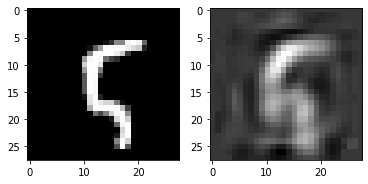

In [81]:
example = 100
fig, axlist = plt.subplots(nrows=1,ncols=2)
axlist[0].imshow(x_train_part[example],cmap='gray'); 
axlist[1].imshow(1*projection_prev_dims[example].astype(float).reshape(28,28),cmap='gray'); plt.show()

--- 
The eigenbases also don't look like much

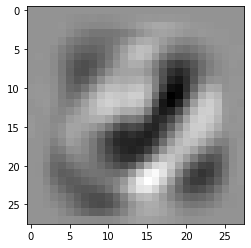

In [82]:
#scaled up eigenvectors
plt.imshow(100*prin_eig_vec[:,5].astype(float).reshape(28,28),cmap='gray')

----

#### Running the same model with lower dimensional dataset

So now let's create a dataset which is the projection of the X values into the top 50 eigenbases (note, all the relevant info is contained in the array with just 50 columns), and see how this performs in our dense network

In [153]:
#dataset
train_data_eig, val_data_eig = create_dataloaders(projection_eig_dims, y,batch_size=200)
#create model with new inputdim
eigenmodel_50 = seven_layer_model(inputdim=projection_eig_dims.shape[1])

#create optimizer linked to this model
optimizer_eig = torch.optim.Adam(eigenmodel_50.parameters())

In [154]:
time_ = time.time()
train_model(eigenmodel_50,train_data_eig, val_data_eig, criterion, optimizer_eig, accuracy_metric, epochs=41,progress=False)
print(f'This took {int(time.time()-time_)} second to train 40 epochs')

End of Model results after 40 epochs:
Train Accuracy:  tensor(0.9951)
Val Accuracy:  tensor(0.9776)
This took 69 second to train 40 epochs


---
#### Testing different number of eigenvectors

We aren't able to achieve quite as strong performance when we have only 50 dimensions. Let's see what happens if we try more / less eigenvectors

In [152]:
list_of_eig_n_to_try = [1,2,5,10,25,50,100,200]
eig_val, eig_vec, cov_matrix = create_eigs(x_flat)

for n in list_of_eig_n_to_try:
    print(f'\nTrying {n} eigenbases:')
    
    projection_eig_dims, projection_prev_dims, P = project_X(eig_vec, x_flat, n)
    projection_prev_dims = projection_prev_dims / 255
    print(f'x has shape {projection_eig_dims.shape}')
    
    
    #dataset
    train_data_eig, val_data_eig = create_dataloaders(projection_eig_dims, y,batch_size=1000)
    
    #create model with new inputdim
    eigenmodel_n = seven_layer_model(inputdim=projection_eig_dims.shape[1])

    #acc
    accuracy_metric = torchmetrics.Accuracy()
    #create optimizer linked to this model
    optimizer_eig = torch.optim.Adam(eigenmodel_n.parameters())
    time_ = time.time()
    train_model(eigenmodel_n,train_data_eig, val_data_eig, criterion, optimizer_eig, accuracy_metric, epochs=41,progress=False)
    print(f'This took {int(time.time()-time_)} second to train')


Trying 1 eigenbases:
x has shape (60000, 1)
End of Model results after 40 epochs:
Train Accuracy:  tensor(0.3044)
Val Accuracy:  tensor(0.3080)
This took 41 second to train

Trying 2 eigenbases:
x has shape (60000, 2)
End of Model results after 40 epochs:
Train Accuracy:  tensor(0.3758)
Val Accuracy:  tensor(0.3732)
This took 43 second to train

Trying 5 eigenbases:
x has shape (60000, 5)
End of Model results after 40 epochs:
Train Accuracy:  tensor(0.7737)
Val Accuracy:  tensor(0.7584)
This took 41 second to train

Trying 10 eigenbases:
x has shape (60000, 10)
End of Model results after 40 epochs:
Train Accuracy:  tensor(0.9484)
Val Accuracy:  tensor(0.9311)
This took 36 second to train

Trying 25 eigenbases:
x has shape (60000, 25)
End of Model results after 40 epochs:
Train Accuracy:  tensor(0.9851)
Val Accuracy:  tensor(0.9673)
This took 41 second to train

Trying 50 eigenbases:
x has shape (60000, 50)
End of Model results after 40 epochs:
Train Accuracy:  tensor(0.9913)
Val Accur

----

##### Conclusion

It's clear that we can achieve the same classification performance from around 50 dimensions. The time to train is slightly unstable, but it appears we can also reduce the training time of the model by around 50% using a lower dimensional representation of the data too.

